# Figure 5: Electrophysiology

In [1]:
from setup_nb import *

### Data

In [2]:
ephys = pd.read_hdf("../data/electrophysiology_.data", "data")

ephys = pd.concat([ephys.xs('Phi', level='Stimulus', drop_level=False),
                   ephys.xs('RPhi', level='Stimulus', drop_level=False)])

In [3]:
ephys.head()

Voltage
Stimulus Direction Fly Time              
Phi      PD        1   0.000000 -0.223884
                       0.000501 -0.158764
                       0.001002 -0.122134
                       0.001503 -0.170974
                       0.002003 -0.170974

In [4]:
# Summary stats for traces, limited to initial 2s of stimulus presentation:
evald = groupexcept(ephys, 'Time').aggregate(rangemean2, r=[0.5, 2.5], slicealong=3).reset_index()

In [5]:
evald.head()

,Stimulus,Direction,Fly,Voltage
0,Phi,ND,1,-0.374022
1,Phi,ND,2,0.073777
2,Phi,ND,3,-0.962598
3,Phi,ND,4,-2.655745
4,Phi,ND,5,-2.298861


In [6]:
phi = evald[(evald.Stimulus == 'Phi') & (evald.Voltage > 6.)]
select = evald[evald.Fly.isin(phi.Fly)]

print "{0} flies fulfil selection criterion of 6mv depolarization upon PD Phi stimulation!".format(
    len(select.Fly.unique()))

23 flies fulfil selection criterion of 6mv depolarization upon PD Phi stimulation!


In [7]:
data_ = ephys.reset_index()

filtered_traces = data_[data_.Fly.isin(phi.Fly)]
filtered_traces.head()

,Stimulus,Direction,Fly,Time,Voltage
17973,Phi,PD,4,0.000000,-1.599688
17974,Phi,PD,4,0.000501,-1.481658
17975,Phi,PD,4,0.001002,-1.469448
17976,Phi,PD,4,0.001503,-1.424678
17977,Phi,PD,4,0.002003,-1.367698


In [8]:
def transform(x):
    
    f = 40  # Factor by which we downsample
    
    ds_time = downsample(x.Time.values, f)
    ds_voltage = downsample(x.Voltage.values, f)
    
    new_df = pd.DataFrame(dict(Time=ds_time, Voltage=ds_voltage))
    
    return new_df

final_traces = filtered_traces.groupby(['Stimulus', 'Direction', 'Fly'], as_index=True).apply(transform).reset_index()

In [9]:
final_traces.head()

,Stimulus,Direction,Fly,level_3,Time,Voltage
0,Phi,ND,4,0,0.009766,0.725112
1,Phi,ND,4,1,0.029800,0.081034
2,Phi,ND,4,2,0.049833,0.203134
3,Phi,ND,4,3,0.069866,-0.048392
4,Phi,ND,4,4,0.089900,0.218091


In [10]:
final_traces.Fly.unique()

array([ 4,  9, 19, 20, 30, 32, 35, 36, 40, 45, 47, 50, 54, 55, 56, 57, 58,
       63, 64, 65, 66, 73, 77])

### Generic plot

In [11]:
def make_trace_panel(data, stim, ax, ylim, legend=False):
    
    current_data = data[data.Stimulus == stim]
    
    sb.tsplot(data=current_data, time="Time", unit="Fly", condition="Direction", value="Voltage",
              ci=standard_ci, color=gt_colors, legend=True, err_kws={'edgecolor': 'none'},
              ax=ax)
    
    ax.legend_.remove()
    
    ax.set_ylim(ylim)
    
    if legend:
        ax.legend(loc=(0.25, 1.3))

    sb.despine(ax=ax)
    ax.axvspan(0.5, 2.5, edgecolor='none', facecolor='gray', zorder=0, alpha=0.075)

#     l = ax.plot([0, 3], [0, 0], linestyle="--", zorder=1, color="#444444")
#     l[0].set_dashes([1,1])

    add_refline(ax, horizontal=True)
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel('Membrane\nvoltage (mV)', labelpad=2.0)
    
    ax.set_yticks([-10, 0, 10, 20])
    ax.set_xticks([0, 1, 2, 3])

In [12]:
def make_summary(data, ax, ylim):
            
#     sb.violinplot(x="Stimulus", y="Voltage", hue="Direction", hue_order=["PD", "ND"],
#                   data=data.reset_index(), palette=gt_colors, ax=ax, linewidth=0.5)
    
    sb.boxplot(x="Stimulus", y="Voltage", hue="Direction", hue_order=["PD", "ND"],
               data=data.reset_index(), palette=gt_colors, ax=ax, whis=np.inf)
    
    ax.legend_.remove()
    ax.legend(loc=(0.6, 0.9))

    sb.plt.xlabel('Stimulus')
    sb.plt.ylabel('Membrane\nvoltage (mV)')

    ax.set_xticklabels(['Phi', 'Reverse'])

    ax.set_ylim(ylim)

    add_refline(ax, horizontal=True)
    sb.despine(ax=ax)

In [13]:
def electrophysiology_figure():
        
    off = 1.7
    rows = [0, 2.3, 4.7]
    panelsize = (2, 2)

    fig = sb.plt.figure(figsize=(3.5, 1.7))
#     fig.suptitle("Leonhardt et al. (2017): Figure 5", fontsize=14)

    height = 1.3
    
    ylim = [-10, 20]
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="a", nudge=0.5)
    make_trace_panel(final_traces, "Phi", ax, legend=False, ylim=ylim)
    ax.set_title("Phi")
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="b", nudge=0.0)
    make_trace_panel(final_traces, "RPhi", ax, legend=False, ylim=ylim)
    remove_axis(ax, y=True)
    ax.set_title("Reverse-phi")
    
    ax = addaxis(fig, (off + rows[2], height), (1.5, 2), letter="c", nudge=0.0)
    make_summary(select, ax, ylim=ylim)
    remove_axis(ax, y=True)
  
    fig.set_frameon(False)
    fig.savefig("../output/Fig5.tif", format="tiff", dpi=standard_dpi)

### Plots

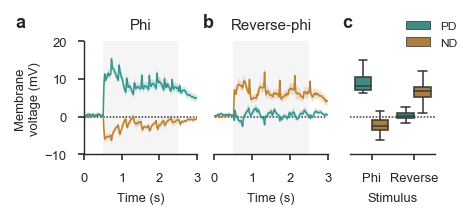

In [14]:
electrophysiology_figure()